The purpose of this notebook is to empirically study the benchmark models that we currently have at our disposal. All of these models are based on our tensor input ie. the tensor $\mathcal{R} \in \mathbb{R}^{T \times L \times N}$, but not all models use a tensor decomposition. 

1. Tensor Factor Models

- Unconstrained tensor factor model (TFM)
- "Flexible" tensor factor model (Naive) $\implies$ relax the assumption that characteristic-based portfolio returns are i.i.d over time
- $1$-Month Horizon tensor factor model (Hor1) $\implies$ note that this is NOT a true "multihorizon" model
- Orthogonal tensor factor model (Ortho)

2. PCA Factor Models

- Pooled PCA $\implies$ note that this is not a TRUE "multihorizon" model
    - hmm it's equally cool that the performance of this method is quite similar to our tensor model, even though it's the exact same portfolio held for all horizons as opposed to one portfolio for each specified horizon
- Multihorizon PCA

3. Non-Factor Models
- Multihorizon Model-Free
- I guess we could also have a Pooled PCA Model-Free Model, but I don't currently have results for that. 

### New models and results

- The PooledPCA Models inspired "Markowitz" and "Orthogonal Markowitz" models
- "TFM with RPPCA Factors" model is a hybrid model that uses the RPPCA factors from the PooledPCA approach, and then inputs this into PARAFAC while fixing it and then jointly estimating the lag loadings and cross-sectional loadings. 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from tfm.parafac_jax import *
from tfm.utils._tensor import *
from tfm.utils._pca import *
jax.config.update("jax_enable_x64", True)

### DEFAULT PARAMETERS ###
window_size = 120
max_lag = 120
start = 'default'
max_horizon = 36
lst_K = {k: i for i, k in enumerate([1, 2, 3, 4, 5, 10, 15, 20, 25])}
lst_lags = [36, 60, 90, 120]
dataset = 'wrds'
year = 1994 if dataset == 'wrds' else 1992
X = jnp.load(f'../organized_data/organized_data/{dataset}/mat_ptf_re_lag_120.npz')['mat_ptf_re_rank']
X_log = jnp.log(1 + X)

### LOADING THE MODELS RESULTS DICTIONARIES ###
dict_tensor_oos = jnp.load(f'../results_oos/multiperiod/{dataset}/tensor_fig_oos_ret_rankptf_ver6/saved_dict_tensor_oos_{year}.pkl', allow_pickle=True)
# dict_orthogonal_tensor_oos = jnp.load(f'../results_oos/multiperiod/{dataset}/tensor_fig_oos_ret_rankptf_ver5/saved_dict_tensor_oos_{year}.pkl', allow_pickle=True)
dict_pca_oos = jnp.load(f'../results_oos/multiperiod/{dataset}/pca_fig_oos_ret_rankptf_ver6/dict_pca_oos_{year}.pkl', allow_pickle=True)
dict_ppca_oos = jnp.load(f'../results_oos/multiperiod/{dataset}/pooled_pca_fig_oos_ret_rankptf_ver5/saved_dict_ppca_oos_{year}.pkl', allow_pickle=True)
dict_hybrid_oos = jnp.load(f'../results_oos/multiperiod/{dataset}/HYBRID_tensor_fig_oos_ret_rankptf_ver5/saved_dict_tensor_oos_{year}.pkl', allow_pickle=True)

### LOADING MODEL-SPECIFIC PARAMETERS ### 
LAGS = 36

TFM = dict_tensor_oos['TFM'][LAGS]
NAIVE = dict_tensor_oos['Naive'][LAGS]
HOR1 = dict_tensor_oos['Hor1'][LAGS]
ORTHO = dict_tensor_oos['Orthogonal'][LAGS]
MARKOWITZ = dict_tensor_oos['Markowitz'][LAGS]
ORTHOGONAL_MARKOWTIZ = dict_tensor_oos['Orthogonal Markowitz'][LAGS]
PCA = dict_pca_oos[-1]
PPCA = dict_ppca_oos['Returns'][LAGS]
HYBRID = dict_hybrid_oos['TFM with RPPCA Factors'][LAGS]

models = {
    "Unconstrained TFM": TFM, 
    "Naive TFM": NAIVE, 
    "Horizon 1 TFM": HOR1, 
    "Orthogonal TFM": ORTHO, 
    "Markowitz": MARKOWITZ, 
    "Orthogonal Markowitz": ORTHOGONAL_MARKOWTIZ, 
    "PooledPCA": PPCA, 
    "TFM with RPPCA Factors": HYBRID
}

In [2]:
T, L, N = X_log.shape
orig = T * L * N
K = 15
print(f"Tensor Model: {(orig - (T + L + N) * K + 1) / orig}% Dimensionality Reduction")
print(f"PooledPCA Model: {(orig - (T + L * N) * K) / orig}% Dimensionality Reduction")

Tensor Model: 0.9982054410504452% Dimensionality Reduction
PooledPCA Model: 0.9641787223844176% Dimensionality Reduction


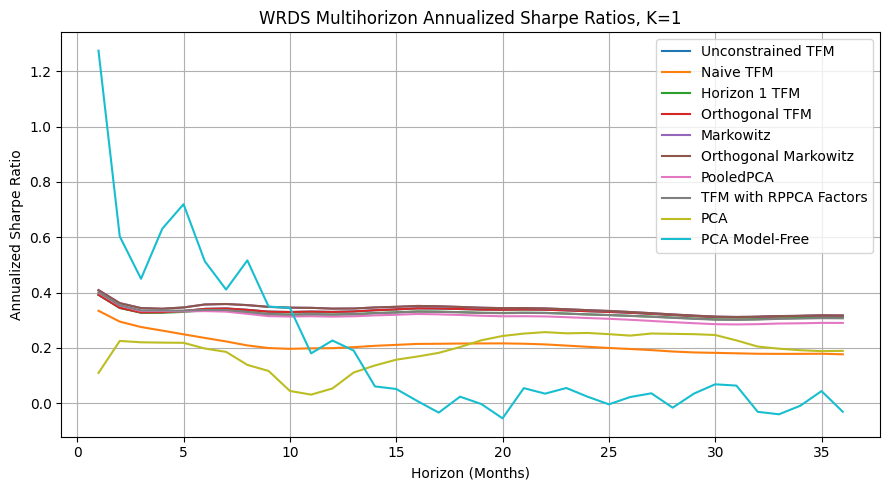

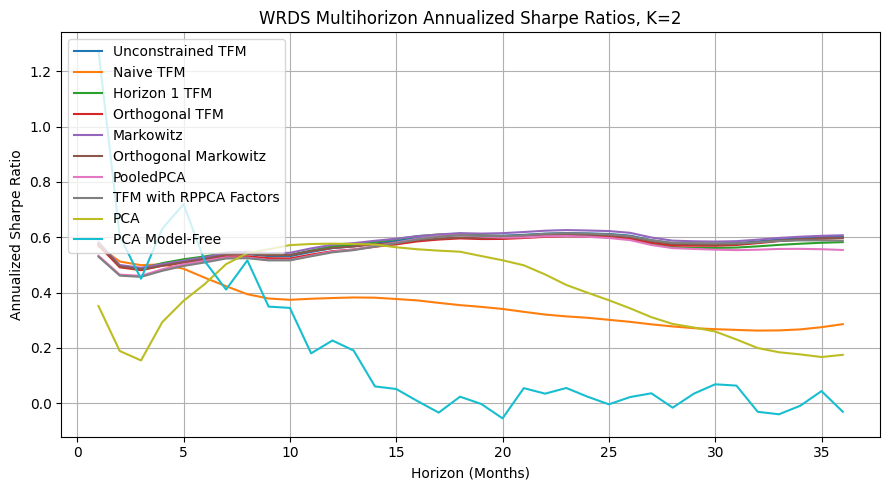

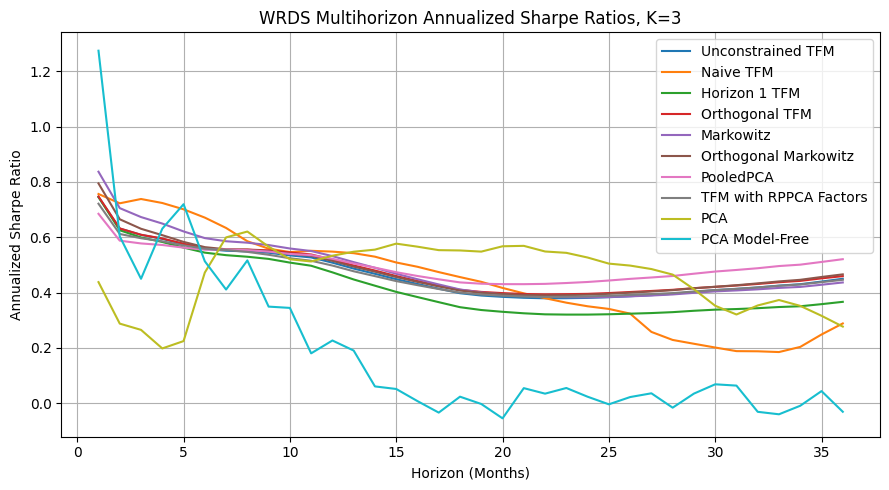

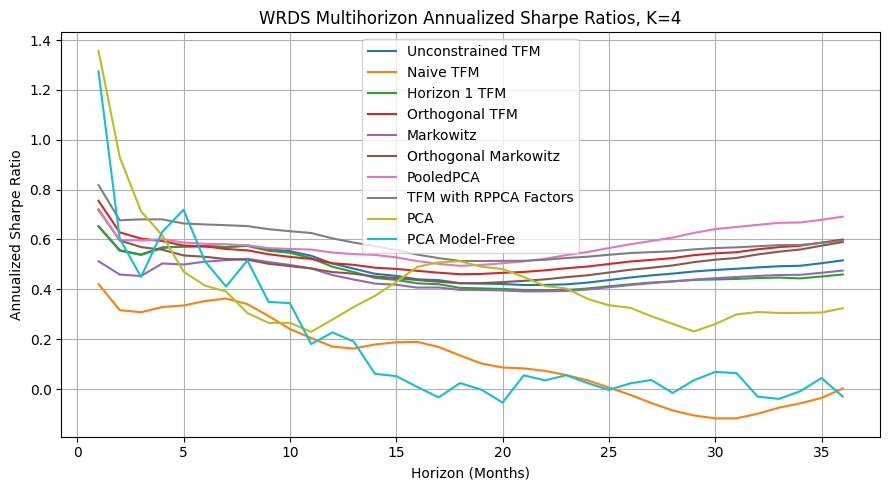

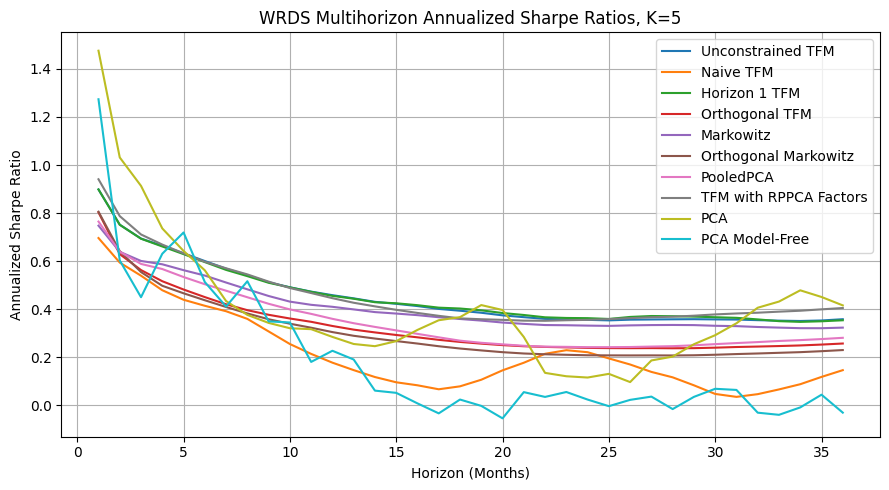

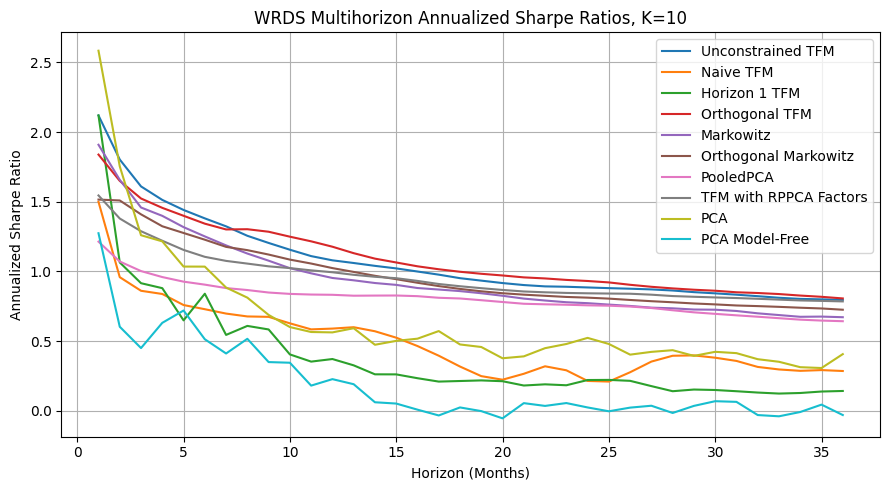

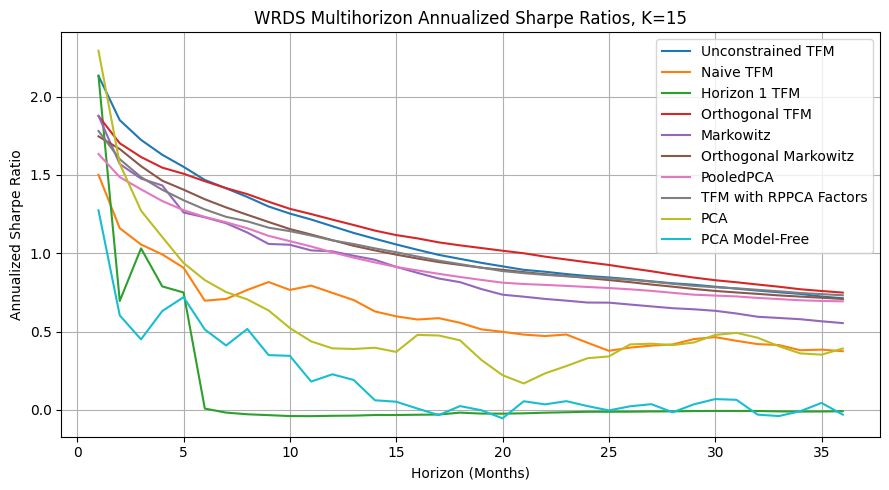

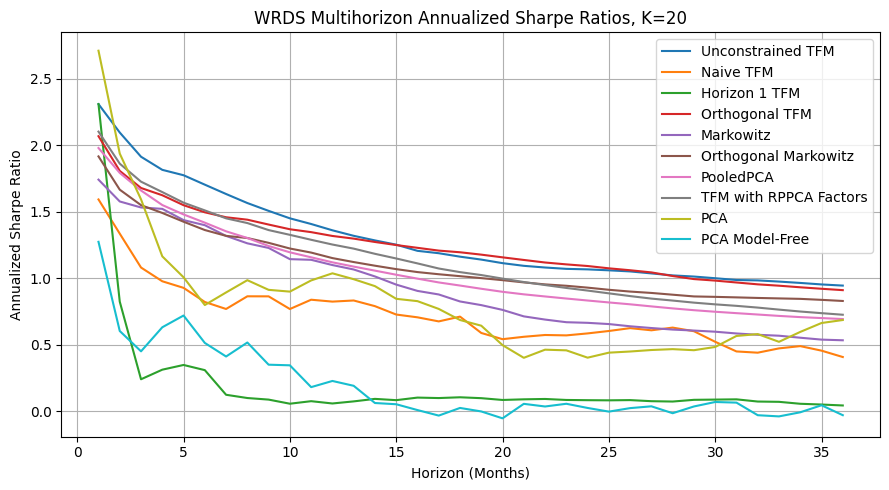

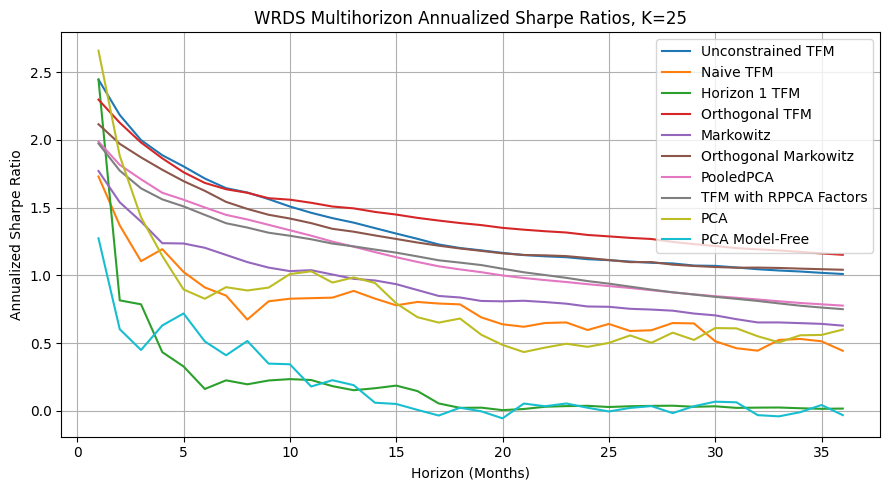

In [3]:
for K in lst_K:
    fig, ax = plt.subplots(figsize=(9, 5))
    for name, model in models.items():
        sr = model.mean(axis=0) / model.std(axis=0)
        annualized_sr_k = sr[:, lst_K[K]] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12)
        ax.plot(jnp.arange(1, max_horizon + 1), annualized_sr_k, label=name)
    
    sr_lst = []
    model_free = []
    for horizon in range(1, max_horizon + 1):
        sr = PCA[horizon].mean(axis=1) / PCA[horizon].std(axis=1)
        sr_lst.append(jnp.expand_dims(sr, axis=0))
        model_free_sr = dict_pca_oos['model_free'][horizon].mean() / dict_pca_oos['model_free'][horizon].std() # dim: scalar
        model_free.append(jnp.expand_dims(model_free_sr, axis=0))

    sr = jnp.concatenate(sr_lst, axis=0) # dim: (max_horizon, len(lst_K))
    model_free = jnp.concatenate(model_free, axis=0) # dim: (max_horizon)
    plot_sr = jnp.concatenate([sr, model_free[..., None]], axis=1)
    
    temp = plot_sr[:, lst_K[K]] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12)
    ax.plot(jnp.arange(1, max_horizon + 1), temp, linestyle='-', label='PCA')
    ax.plot(jnp.arange(1, max_horizon + 1), plot_sr[:, -1] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12), linestyle='-', label='PCA Model-Free')

    ax.set_title(f"{dataset.upper()} Multihorizon Annualized Sharpe Ratios, K={K}")
    ax.set_xlabel("Horizon (Months)")
    ax.set_ylabel("Annualized Sharpe Ratio")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

1. Imposing orthgonality on the time series factors mode DOES worsen the fit of the model, as expected. We can see this by comparing the reconstruction errors of the Orthogonal TFM and the Unconstrained TFM. Furthermore, for short-tern horizons, the orthogonal model performs worse than the unconstrained model. However, for longer horizons, the orthogonal model performs better than the unconstrained model, leading me to believe that the orthogonal factors are more persistent, robust, and perhaps more economically meaningful. 

Some more observations that I noticed are: 

2. It's a little bit hard to see, but "TFM with RPPCA Factors" does MARGINALLY better than PooledPCA (maybe not even), but this could be statistically insignificant. It was an interesting idea, but I don't think it's worth exploring too much further, as the fundamental premise is that PARAFAC identifies all modes jointly.
- To be fair, "TFM with RPPCA Factors" incorporates multihorizon effects, and PooledPCA does not. Not sure how comparable these approaches really are... need to think more about this 

3. In all models, the time series factors are of the utmost importance because they reflect the multihorizon effects present in the loadings matrices. In this sense, PooledPCA, Markowitz, and Orthogonal Markowitz are all comparable because they are all just $\omega = (\Sigma^{F, S})^{-1}\mu^{F, S}$
- Order in terms of performance usually goes, Orthogonal Markowitz > Markowitz > PooledPCA. One can really see the improvement in the performance of Orthogonal Markowitz over Markowitz when $K$ is large, in the plots below. 

4. 


- TFM distinguishes itself from PooledPCA when the number of characteristics is large? 
- When $K \leq 5$, the Horizon $1$ model usually performs on par with Unconstrained TFM and PooledPCA models

Also have results for the SCS dataset and Characteristics Anomalies dataset, but they're not as convincing and supporting of our model. 

# NOTE THE COLOR CHANGE; BELOW, TRYING FOR LARGER K

In [7]:
lst_K = {k: i for i, k in enumerate([50, 100])}
models = {
    "Unconstrained TFM": TFM, 
    "Naive TFM": NAIVE, 
    "Horizon 1 TFM": HOR1, 
    "Orthogonal TFM": ORTHO, 
    "Markowitz": MARKOWITZ, 
    "Orthogonal Markowitz": ORTHOGONAL_MARKOWTIZ, 
    # "PooledPCA": PPCA, 
    # "TFM with RPPCA Factors": HYBRID
}

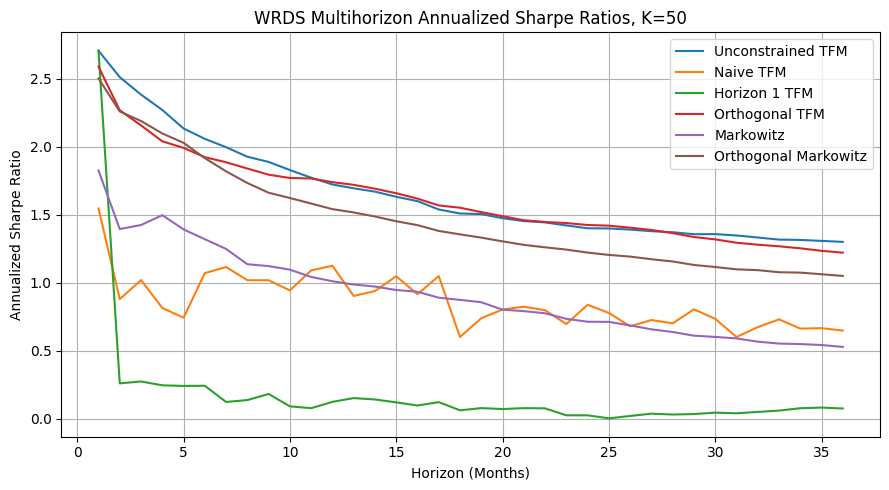

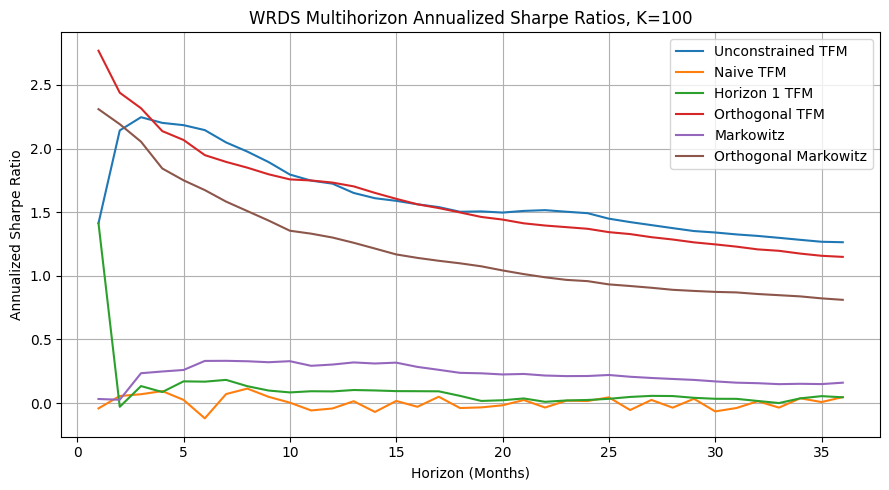

In [8]:
for K in lst_K:
    fig, ax = plt.subplots(figsize=(9, 5))
    for name, model in models.items():
        sr = model.mean(axis=0) / model.std(axis=0)
        annualized_sr_k = sr[:, lst_K[K] + 9] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12)
        ax.plot(jnp.arange(1, max_horizon + 1), annualized_sr_k, label=name)
    
    # sr_lst = []
    # model_free = []
    # for horizon in range(1, max_horizon + 1):
    #     sr = PCA[horizon].mean(axis=1) / PCA[horizon].std(axis=1)
    #     sr_lst.append(jnp.expand_dims(sr, axis=0))
    #     model_free_sr = dict_pca_oos['model_free'][horizon].mean() / dict_pca_oos['model_free'][horizon].std() # dim: scalar
    #     model_free.append(jnp.expand_dims(model_free_sr, axis=0))

    # sr = jnp.concatenate(sr_lst, axis=0) # dim: (max_horizon, len(lst_K))
    # model_free = jnp.concatenate(model_free, axis=0) # dim: (max_horizon)
    # plot_sr = jnp.concatenate([sr, model_free[..., None]], axis=1)
    
    # temp = plot_sr[:, lst_K[K] + 9] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12)
    # ax.plot(jnp.arange(1, max_horizon + 1), temp, linestyle='-', label='PCA')
    # ax.plot(jnp.arange(1, max_horizon + 1), plot_sr[:, -1] * jnp.sqrt(1 / jnp.arange(1, max_horizon + 1)) * jnp.sqrt(12), linestyle='-', label='PCA Model-Free')

    ax.set_title(f"{dataset.upper()} Multihorizon Annualized Sharpe Ratios, K={K}")
    ax.set_xlabel("Horizon (Months)")
    ax.set_ylabel("Annualized Sharpe Ratio")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()